In [1]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u

## Open a test data

In [2]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [3]:
cosmo = extragalactic_cat.cosmology

In [4]:
#DC2 full
#filters = ['mag_i_lsst<25.','redshift>0.9','redshift<1.1'] 


filters = ['redshift<10', 'mag_i_lsst<26.']

gal_selection = extragalactic_cat.get_quantities(['is_central', 'halo_mass','mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst', 'redshift','ra', 'dec', 'shear_1', 'shear_2', 'convergence'], filters=filters)

In [5]:
gal_cat = Table(gal_selection)
len(gal_cat)/1e6

17.759198

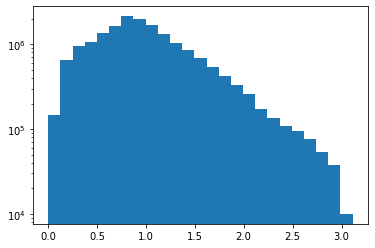

In [6]:
mag_hist = plt.hist(gal_cat['redshift'],bins=25);
plt.yscale('log')

# Color selection definition

In [7]:
## Filter conversion to Johnson and Steidel filters

## (U−G) = 0.97 (u−g)  +  1.27
## (G−R) = 0.32 (r−i)  +  1.11

In [8]:
## definitions from https://iopscience.iop.org/article/10.1086/426580/pdf

### LBG

‘LBG’’ selection criteria of Steidel et al. (2003)

Un-G >= (G - R) + 1 \
G - R <= 1.2

In [9]:
# in Johnson filter : 

In [10]:
## 0.97 (u-g) + 1.27 > 0.32 (r-1) + 1.11 + 1
## 0.32 (r-i) + 1.11 <= 1.2

### (u-g)  > 0.33 (r-i) + 0.87
### (r - i) <= 0.28

### BM

‘‘BM’’ selection criteria of Adelberger et al. (2004)

G - R >= - 0.2 \
Un - G >= (G-R) - 0.1 \
G - R  <= 0.2*(Un-G) + 0.4 \
Un - G <= (G-R) + 0.2

In [11]:
# in Johnson filter : 

In [12]:
## 0.32 (r-i) + 1.11 >= - 0.2
## 0.97 (u-g) + 1.27 > 0.32 (r-i) + 1.11 - 0.1
## 0.32 (r-i) + 1.11 < 0.2*(0.97 (u-g) + 1.27)  + 0.4
## 0.97 (u-g) + 1.27 <  0.32 (r-i) + 1.11 + 0.2

### (r-i) > - 4.09
### (u-g) > 0.33 (r-i) - 0.27
### (r-i) < 0.61*(u-g) - 1.42
### (u-g) <  0.33 (r-i) + 0.04

### BX

‘‘BX’’ selection criteria of Adelberger et al. (2004)

G - R >= - 0.2 \
Un - G >= (G-R) + 0.2 \
G - R  <= 0.2*(Un-G) + 0.4 \
Un - G <= (G-R) + 1.0

In [19]:
# in Johnson filter : 

In [20]:
### (r-i) <  0.60625 (u-g) - 1.425

In [21]:
## 0.32 (r-i) + 1.11 >= - 0.2
## 0.97 (u-g) + 1.27 > 0.32 (r-i) + 1.11 + 0.2
## 0.32 (r-i) + 1.11 < 0.2*(0.97 (u-g) + 1.27)  + 0.4
## 0.97 (u-g) + 1.27 <  0.32 (r-i) + 1.11 + 1

### (r-i) > - 4.09
### (u-g) >  0.33 (r-i) + 0.04
### (r-i) <  0.61 (u-g) - 1.42
### (u-g) <  0.33 (r-i) + 0.87

## u - dropouts 
(https://arxiv.org/pdf/1904.13378.pdf p. 11)

### (u−g)>1.5
### −1.0<(g−r)<1.2
### 1.5(g−r)<(u−g)−0.75

# Color selection

In [51]:
u_min_g = gal_cat['mag_u_lsst'] - gal_cat['mag_g_lsst']
g_min_r = gal_cat['mag_g_lsst'] - gal_cat['mag_r_lsst']
r_min_i = gal_cat['mag_r_lsst'] - gal_cat['mag_i_lsst']

r_min_z = gal_cat['mag_r_lsst'] - gal_cat['mag_z_lsst']
g_min_i = gal_cat['mag_g_lsst'] - gal_cat['mag_i_lsst']

In [23]:
## LBG : 

In [24]:
LBG = (u_min_g > 0.33 * r_min_i + 0.87) * (r_min_i<0.28)  

In [25]:
len(gal_cat[LBG])/len(gal_cat)

0.044173954251762945

In [26]:
## BM : 

In [27]:
BM = (r_min_i  > -4.09) * (u_min_g > 0.33*r_min_i  - 0.27) * (r_min_i < 0.61*u_min_g - 1.42) * (u_min_g <  0.33*r_min_i + 0.04)

In [28]:
len(gal_cat[BM])/len(gal_cat)

0.0

In [29]:
## BX : 

In [30]:
BX = (r_min_i  > -4.09) * (u_min_g > 0.33*r_min_i  + 0.04) * (r_min_i < 0.61*u_min_g - 1.42) * (u_min_g <  0.33*r_min_i + 0.87)

In [31]:
len(gal_cat[BX])/len(gal_cat)

0.0

In [32]:
## U-dropouts

In [33]:
U_drop = (u_min_g>1.5) * (g_min_r> -1.) * (g_min_r<1.2) * (1.5*g_min_r < u_min_g-0.75)

In [34]:
len(gal_cat[U_drop])/len(gal_cat)

0.0021919345682164253

Text(0.5, 0, 'i mag')

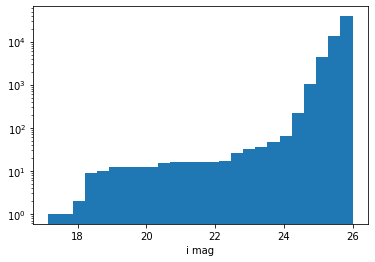

In [35]:
plt.hist(gal_cat['mag_i_lsst'][U_drop], bins=25,cumulative=True);
plt.yscale('log')

plt.xlabel('i mag')

(-1.0, 6.0)

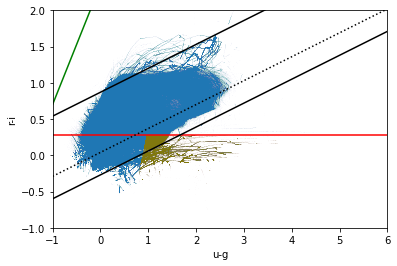

In [36]:
ug = np.linspace(-1, 10, 10)
ri = np.linspace(-1, 10, 10)

plt.scatter(u_min_g, r_min_i, s = 0.1, alpha=0.01)
plt.scatter(u_min_g[LBG], r_min_i[LBG], s = 0.1, alpha=0.01)


plt.xlabel('u-g')
plt.ylabel('r-i')

plt.axhline(-4.09, color='red')
plt.axhline(0.28, color='red')

plt.plot(ug, 0.33*ri - 0.27, color='black')
plt.plot(ug, 0.33*ri + 0.04, color = 'black', linestyle='dotted')
plt.plot(ug, 0.33*ri + 0.87, color='black')

plt.plot(ug, 1.65*ri + 2.35, color='green')

plt.ylim(-1, 2)
plt.xlim(-1, 6)

# Redshift distribution of the color selection

In [37]:
mag_i = gal_cat['mag_i_lsst']

In [38]:
# LBG

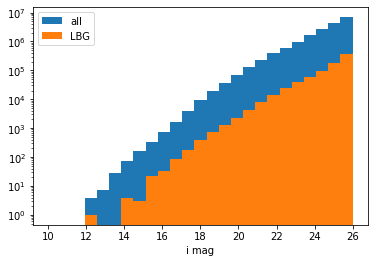

In [39]:
mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=25, range=[10,26], label='all');
plt.hist(gal_cat['mag_i_lsst'][LBG],bins=25,range=[10,26], label ='LBG');
plt.yscale('log')

plt.xlabel('i mag')
plt.legend()

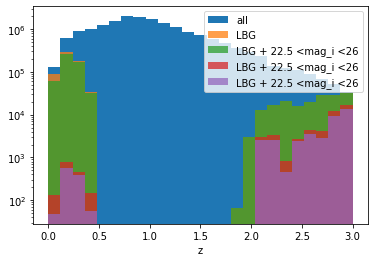

In [40]:
mag_hist = plt.hist(gal_cat['redshift'],bins=25, range=[0,3], label ='all');
plt.hist(gal_cat['redshift'][LBG],bins=25, range=[0,3], label ='LBG',alpha=0.75);
plt.hist(gal_cat['redshift'][LBG * (mag_i<26) * (mag_i>23.)],bins=25, range=[0,3], label ='LBG + 22.5 <mag_i <26',alpha=0.75);
plt.hist(gal_cat['redshift'][LBG *(u_min_g>1.4)],bins=25, range=[0,3], label ='LBG + 22.5 <mag_i <26',alpha=0.75);
plt.hist(gal_cat['redshift'][LBG *(u_min_g>1.5)* (mag_i<26) * (mag_i>23.)],bins=25, range=[0,3], label ='LBG + 22.5 <mag_i <26',alpha=0.75);

plt.yscale('log')
plt.xlabel('z')

plt.legend()

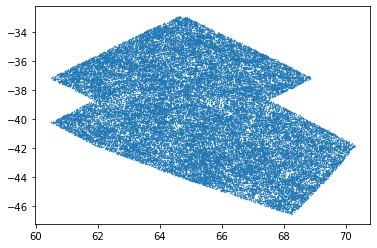

In [41]:
plt.scatter(gal_cat['ra'][LBG * (mag_i<26) * (mag_i>23.)*(u_min_g>1.4)], gal_cat['dec'][LBG * (mag_i<26) * (mag_i>23.)*(u_min_g>1.4)], s=0.1)

In [42]:
gal_cat['ra'][LBG * (mag_i<26) * (mag_i>23.)*(u_min_g>1.4)].size/54.

973.5185185185185

In [43]:
conv = (1/(u.deg*u.deg)).to(1/u.arcmin**2)

In [44]:
(gal_cat['ra'][LBG * (mag_i<26) * (mag_i>23.)*(u_min_g>1.4)].size/54.) * conv 

<Quantity 0.27042181 1 / arcmin2>

In [45]:
1e4 * conv 

<Quantity 2.77777778 1 / arcmin2>

In [46]:
170 * conv 

<Quantity 0.04722222 1 / arcmin2>

Text(0.5, 0, 'z')

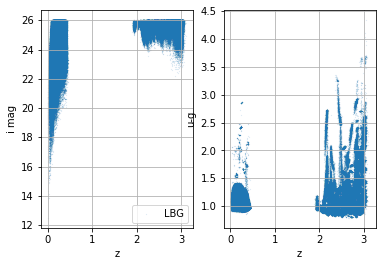

In [47]:
plt.subplot(121)
plt.scatter(gal_cat['redshift'][LBG], mag_i[LBG], s=0.01, label ='LBG',alpha=0.5)
plt.grid()

plt.ylabel('i mag')
plt.xlabel('z')

plt.legend()


plt.subplot(122)
plt.scatter(gal_cat['redshift'][LBG], u_min_g[LBG], s=0.01, label ='LBG',alpha=0.5)
plt.grid()

plt.ylabel('u-g')
plt.xlabel('z')


In [48]:
# U-drop

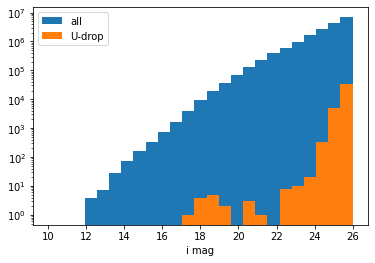

In [49]:
mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=25, range=[10,26], label='all');
plt.hist(gal_cat['mag_i_lsst'][U_drop],bins=25,range=[10,26], label='U-drop');
plt.yscale('log')

plt.xlabel('i mag')
plt.legend()

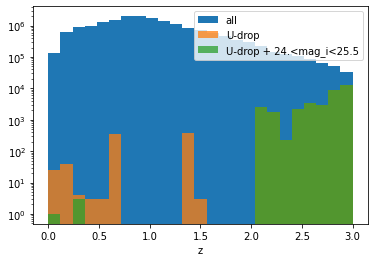

In [52]:
mag_hist = plt.hist(gal_cat['redshift'],bins=25, range=[0,3], label='all');
plt.hist(gal_cat['redshift'][U_drop],bins=25, range=[0,3], label='U-drop',alpha=0.75);
plt.hist(gal_cat['redshift'][U_drop*(r_min_z<0.5)],bins=25, range=[0,3], label='U-drop + 24.<mag_i<25.5',alpha=0.75);

plt.yscale('log')

plt.xlabel('z')
plt.legend()

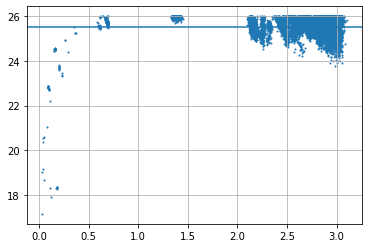

In [53]:
plt.scatter(gal_cat['redshift'][U_drop], mag_i[U_drop], s=1)
plt.grid()

plt.axhline(25.5)

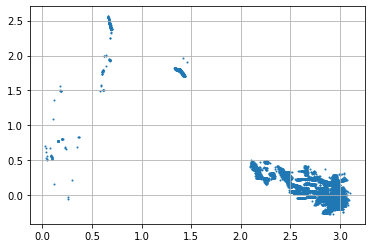

In [54]:
plt.scatter(gal_cat['redshift'][U_drop], r_min_z[U_drop], s=1)
plt.grid()


# Comparison to cluster member colors

In [55]:
cluster_member = (gal_cat['halo_mass']> 5e13)

Text(0, 0.5, 'g-i')

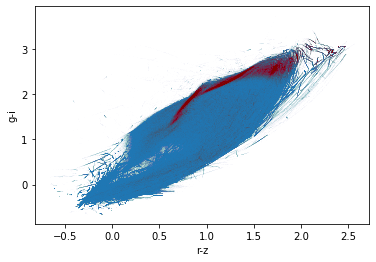

In [56]:
plt.scatter(r_min_z, g_min_i, s = 0.1, alpha=0.01)
plt.scatter(r_min_z[cluster_member], g_min_i[cluster_member], s = 0.1, c='red', alpha=0.01)

plt.xlabel('r-z')
plt.ylabel('g-i')

In [57]:
r_min_z = gal_cat['mag_r_lsst'] - gal_cat['mag_z_lsst']
u_min_g = gal_cat['mag_u_lsst'] - gal_cat['mag_g_lsst']

Text(0, 0.5, 'u-g')

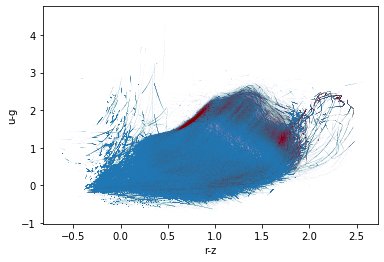

In [58]:
plt.scatter(r_min_z, u_min_g, s = 0.1, alpha=0.01)
plt.scatter(r_min_z[cluster_member], u_min_g[cluster_member], s = 0.1, c='red', alpha=0.01)

plt.xlabel('r-z')
plt.ylabel('u-g')

# Color-cut definition in Medezinski et al. 2018  
- https://arxiv.org/pdf/1706.00427.pdf

Text(0, 0.5, 'g-i')

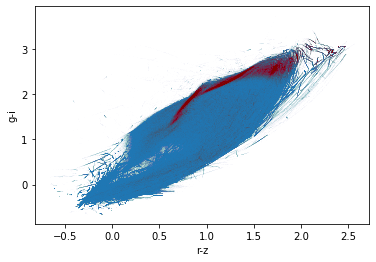

In [59]:
plt.scatter(r_min_z, g_min_i, s = 0.1, alpha=0.01)
plt.scatter(r_min_z[cluster_member], g_min_i[cluster_member], s = 0.1, c='red', alpha=0.01)

plt.xlabel('r-z')
plt.ylabel('g-i')

In [60]:
CCseq_ll = 2.276 * (r_min_z) - 0.152
CCseq_T = -1/2.276 * (r_min_z) - 0.152/2.276**2

rzseq_ll = - 0.0248 * gal_cat['mag_z_lsst'] + 1.604

red_color1 = g_min_i - CCseq_ll

red_color2 = (g_min_i - CCseq_T) / (1 + 1/2.276**2)

blue_color1 = (r_min_z - rzseq_ll)
blue_color2 = red_color2

#selection to avoid cluster galaxies at z<0.4
sel_red1 = (red_color1 < -0.7) * (red_color2 < 4.) * (r_min_z>0.5)  # * (gal_cat['mag_z_lsst']>21)
sel_blue1 = ((blue_color1 < -0.8) | ((blue_color2 < 0.5) * (g_min_i < 4)))  * (r_min_z<0.5)#   * (gal_cat['mag_z_lsst']>22)

#selection to avoid cluster galaxies at z>0.4
sel_red2 = (red_color1 < -0.8) * (red_color2 < 1.7) * (r_min_z>0.5)  #* (gal_cat['mag_z_lsst']>21)
sel_blue2 = ((blue_color1 < -0.9) | ((blue_color2 < 0.3) * (g_min_i < 4)))  * (r_min_z<0.5)  # * (gal_cat['mag_z_lsst']>22)


(-0.5, 3.5)

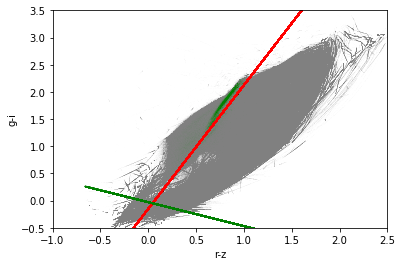

In [61]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

plt.scatter(r_min_z, g_min_i, s = 0.1, alpha=0.01, color='grey')
plt.scatter(r_min_z[cluster_member * (gal_cat['redshift']<0.4)], g_min_i[cluster_member* (gal_cat['redshift']<0.4)], s = 0.1, c='green', alpha=0.01)

plt.plot(r_min_z, CCseq_ll, 'r')
plt.plot(r_min_z, CCseq_T, 'g')

plt.xlabel('r-z')
plt.ylabel('g-i')

plt.xlim(-1, 2.5)
plt.ylim(-0.5, 3.5)

Text(0, 0.5, 'g-i')

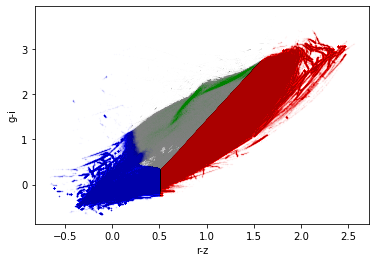

In [62]:
plt.scatter(r_min_z, g_min_i, s = 0.1, alpha=0.01, color='grey')
plt.scatter(r_min_z[cluster_member], g_min_i[cluster_member], s = 0.1, c='green', alpha=0.01)

plt.scatter(r_min_z[sel_red1], g_min_i[sel_red1], s = 1, c='red', alpha=0.01)
plt.scatter(r_min_z[sel_blue1], g_min_i[sel_blue1], s = 1, c='blue', alpha=0.01)

plt.xlabel('r-z')
plt.ylabel('g-i')

Text(0, 0.5, 'g-i')

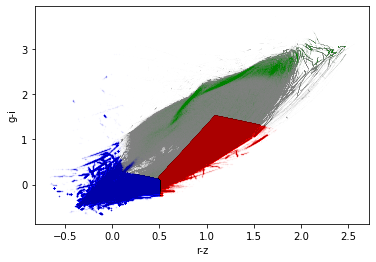

In [63]:
plt.scatter(r_min_z, g_min_i, s = 0.1, alpha=0.01, color='grey')
plt.scatter(r_min_z[cluster_member], g_min_i[cluster_member], s = 0.1, c='green', alpha=0.01)

plt.scatter(r_min_z[sel_red2], g_min_i[sel_red2], s = 1, c='red', alpha=0.01)
plt.scatter(r_min_z[sel_blue2], g_min_i[sel_blue2], s = 1, c='blue', alpha=0.01)

plt.xlabel('r-z')
plt.ylabel('g-i')

# Summarize color selection and compute source number density 

In [64]:
sky_area = extragalactic_cat.sky_area
print( sky_area, 'deg2')

57.07196787435936 deg2


In [65]:
conv = (1/(u.deg*u.deg)).to(1/u.arcmin**2)

## - LBG

In [66]:
LBG = (u_min_g > 0.33 * r_min_i + 0.87) * (r_min_i<0.28)  

In [67]:
LBG_dens = len(gal_cat[LBG])/(sky_area*u.deg*u.deg)
print( LBG_dens, LBG_dens.value*conv)

13745.697392580158 1 / deg2 3.8182492757167097 1 / arcmin2


## - LBG*

In [68]:
LBGp = LBG * (u_min_g>1.4)

In [69]:
LBGp_dens = len(gal_cat[LBGp])/(sky_area*u.deg*u.deg)
print( LBGp_dens, LBGp_dens.value*conv)

928.5293984721366 1 / deg2 0.25792483290892676 1 / arcmin2


## -U-drop

In [70]:
Udrop = (u_min_g>1.5) * (g_min_r> -1.) * (g_min_r<1.2) * (1.5*g_min_r < u_min_g-0.75)

In [71]:
Udrop_dens = len(gal_cat[Udrop])/(sky_area*u.deg*u.deg)
print( Udrop_dens, Udrop_dens.value*conv)

682.0686485823574 1 / deg2 0.18946351349509924 1 / arcmin2


## - U-drop*

In [72]:
Udropp = Udrop * (r_min_z<0.5)

In [73]:
Udropp_dens = len(gal_cat[Udropp])/(sky_area*u.deg*u.deg)
print( Udropp_dens, Udropp_dens.value*conv)

668.0162156652805 1 / deg2 0.18556005990702232 1 / arcmin2


## - Medezinski_2018 color-cuts

In [74]:
CCseq_ll = 2.276 * (r_min_z) - 0.152
CCseq_T = -1/2.276 * (r_min_z) - 0.152/2.276**2

rzseq_ll = - 0.0248 * gal_cat['mag_z_lsst'] + 1.604

red_color1 = g_min_i - CCseq_ll

red_color2 = (g_min_i - CCseq_T) / (1 + 1/2.276**2)

blue_color1 = (r_min_z - rzseq_ll)
blue_color2 = red_color2

In [75]:
#selection to avoid cluster galaxies at z<0.4
sel_red1 = (red_color1 < -0.7) * (red_color2 < 4.) * (r_min_z>0.5) # * (gal_cat['mag_i_lsst']>21)
sel_blue1 = ((blue_color1 < -0.8) | ((blue_color2 < 0.5) * (g_min_i < 4)))  * (r_min_z<0.5) # * (gal_cat['mag_i_lsst']>22)

#selection to avoid cluster galaxies at z>0.4
sel_red2 = (red_color1 < -0.8) * (red_color2 < 1.7) * (r_min_z>0.5)  #* (gal_cat['mag_z_lsst']>21)
sel_blue2 = ((blue_color1 < -0.9) | ((blue_color2 < 0.3) * (g_min_i < 4)))  * (r_min_z<0.5)  # * (gal_cat['mag_i_lsst']>22)


In [76]:
MedezinskyR1_dens = len(gal_cat[sel_red1])/(sky_area*u.deg*u.deg)
print(MedezinskyR1_dens, MedezinskyR1_dens.value*conv)

MedezinskyR2_dens = len(gal_cat[sel_red2])/(sky_area*u.deg*u.deg)
print(MedezinskyR2_dens, MedezinskyR2_dens.value*conv)

MedezinskyB1_dens = len(gal_cat[sel_blue1])/(sky_area*u.deg*u.deg)
print(MedezinskyB1_dens, MedezinskyB1_dens.value*conv)

MedezinskyB2_dens = len(gal_cat[sel_blue2])/(sky_area*u.deg*u.deg)
print(MedezinskyB2_dens, MedezinskyB2_dens.value*conv)

140467.03309141833 1 / deg2 39.01862030317175 1 / arcmin2
85056.69562133511 1 / deg2 23.626859894815304 1 / arcmin2
63190.5493067858 1 / deg2 17.55293036299605 1 / arcmin2
53729.68751928499 1 / deg2 14.924913199801383 1 / arcmin2


## Redshift distribution : 

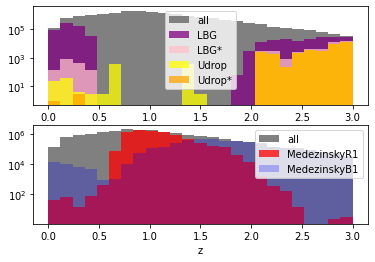

In [77]:
plt.subplot(211)

mag_hist = plt.hist(gal_cat['redshift'],bins=25, range=[0,3], label='all', color='grey');
plt.hist(gal_cat['redshift'][LBG],bins=25, range=[0,3], label='LBG',alpha=0.75, color='purple');
plt.hist(gal_cat['redshift'][LBGp],bins=25, range=[0,3], label='LBG*',alpha=0.75, color='pink');

plt.hist(gal_cat['redshift'][Udrop],bins=25, range=[0,3], label='Udrop',alpha=0.75, color='yellow');
plt.hist(gal_cat['redshift'][Udropp],bins=25, range=[0,3], label='Udrop*',alpha=0.75, color='orange');

plt.yscale('log')

plt.xlabel('z')
plt.legend()


plt.subplot(212)

plt.hist(gal_cat['redshift'],bins=25, range=[0,3], label='all', color='grey');
plt.hist(gal_cat['redshift'][sel_red1],bins=25, range=[0,3], label='MedezinskyR1',alpha=0.75, color='red');
#plt.hist(gal_cat['redshift'][sel_red2],bins=25, range=[0,3], label='MedezinskyR2',alpha=0.75, color='magenta');
plt.hist(gal_cat['redshift'][sel_blue1],bins=25, range=[0,3], label='MedezinskyB1',alpha=0.25, color='blue');
#plt.hist(gal_cat['redshift'][sel_blue2],bins=25, range=[0,3], label='MedezinskyB2',alpha=0.25, color='cyan');

plt.yscale('log')

plt.xlabel('z')
plt.legend()